# Multinomial Logistic Regression
First prediction method to be tested will be the multinomial logistic regression model. It will serve as a comparative baseline for more advanced models such as Random Forest or neural networks like Convolutional Neural Network. It is a multinomial logistic regression, because it is a classifier with multiple class options.


In [20]:
# Imports

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [21]:
train_data_path = 'data/fashion-mnist_train.csv'
test_data_path = 'data/fashion-mnist_test.csv'

In [22]:
def getData(path):
    data = pd.read_csv(path)
    X = data.drop('label', axis=1)
    y = data['label']
    return X, y

In [ ]:
def runLogisticRegression(X, y):
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    model = LogisticRegression(max_iter=10000)
    results = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    return results

In [23]:
X, y = getData(train_data_path)

### Dimensionality reduction using PCA
Because the training data consists of 60000 sample images where each image is made up of 784 pixels (28x28 pixels), running a simple Multinomial Logistic Regression with 5-fold CV is time consuming to calculate. In order to attempt to reduce the processing time, I will investigate whether the dataset can be reduced through reducing the number of features using PCA.

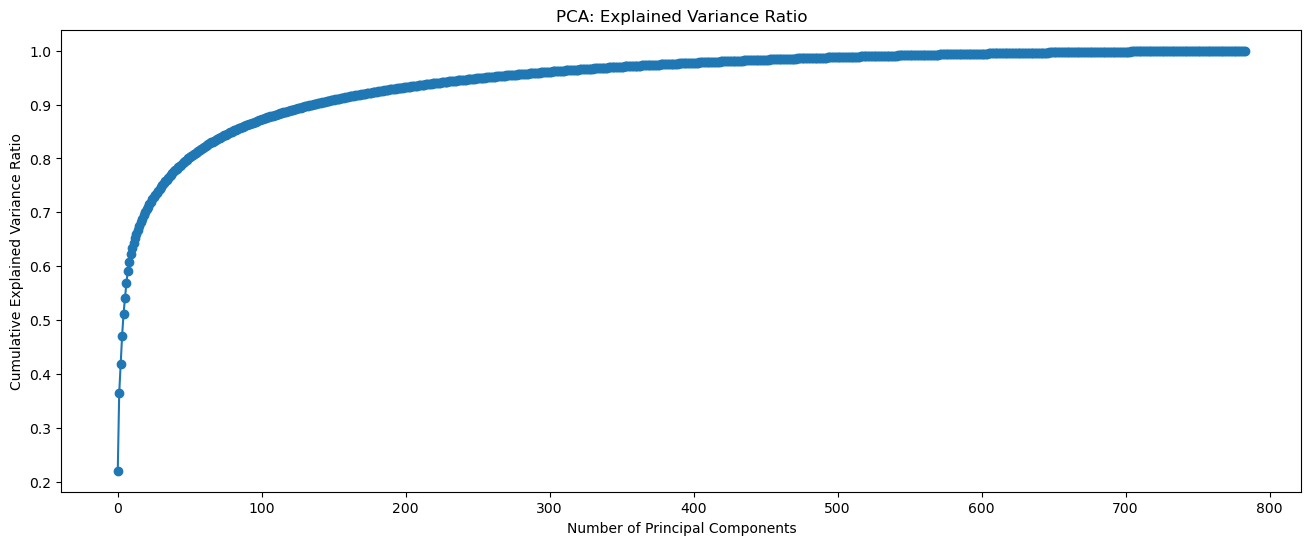

In [ ]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_reduced = pca.fit_transform(X_scaled)

# Get explained variance
explained_variance = pca.explained_variance_
total_variance = explained_variance.sum()

# Plot the explained variance ratio
plt.figure(figsize=(16, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Explained Variance Ratio')
plt.show()

From the plot it is clear that the far majority of the fatures are not necessary. By simply reducing the number of features to 200, it can still retain close to 90% of the variance. I will experiement with features in the range from 50 to 200, possibly landing somewhere closer to 200 features total, which is still an overall data reduction from near 800 original features.

In [40]:
# Experiment with different numbers of PCA components

for i in range(1, 5):
    num_components = i * 50
    X_reduced = PCA(n_components=num_components).fit_transform(X_scaled)
    results = runLogisticRegression(X_reduced, y)
    print(f'Accuracy with {num_components} PCA components:')
    print(f'Accuracy for each fold: {results}')
    print(f'Average accuracy: {results.mean():.2f}')


Accuracy with 50 PCA components:
Accuracy for each fold: [0.8325     0.83466667 0.83691667 0.83083333 0.83283333]
Average accuracy: 0.83
Accuracy with 100 PCA components:
Accuracy for each fold: [0.84666667 0.84491667 0.85041667 0.84375    0.84825   ]
Average accuracy: 0.85
Accuracy with 150 PCA components:
Accuracy for each fold: [0.85291667 0.85208333 0.85341667 0.84958333 0.85308333]
Average accuracy: 0.85
Accuracy with 200 PCA components:
Accuracy for each fold: [0.854      0.85216667 0.85558333 0.85091667 0.85575   ]
Average accuracy: 0.85


Finally, I had to increase the number of maximum iterations for Logistic Regression, since it struggled to converge for larger amounts of features relative to the features in the dataset. That means that even for the lowest amount of features I would test (50 features) would result in the model not reaching convergence with a max iteration set to 1000. Therefore, I decided to increase the limitation to 2000, which allowed it model to converge. 

Also note that from the above accuracy results for a range of different number of PCA components, the accuracy does not become much better after 50 components when seen relative to the amount of extra components used for each new training round. Therefore, I will only use 50 components for the final performance evaluation on the test set.

### LR - Model Accuracy on Test Data
In the following code, it will run the Logistic Regression model (using only 50 features) on the separate test data set. This will show how well the model works for unseen data, and will also reveal whether the model might have overfitted to the training dataset.

In [7]:
# Test data:
test_data = pd.read_csv('data/fashion-mnist_test.csv')
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

In [9]:
# Chosen model:
model = LogisticRegression(max_iter=10000)
X_reduced = PCA(n_components=50).fit_transform(X_scaled)
model.fit(X_reduced, y)

# Predict on test data
X_test_scaled = scaler.transform(X_test)
X_test_reduced = PCA(n_components=50).fit_transform(X_test_scaled)
y_pred = model.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Model Accuracy on test data: {accuracy}, and in percentage: {accuracy * 100:.2f}%')

Logistic Regression Model Accuracy on test data: 0.3699, and in percentage: 36.99%


## Model Evalution
From the above results, it would be fair to assume that the model has become too complex from overfitting to the training data. To try and mitigate it, I could add regularization to the model. It could also be due to an excessive amount of features, even after the decrease from nearly 800 features to just 50 features. So, it could be an idea to run a new round of training and testing with even fewer features (at the cost of accuracy on the training data), and possibly also introduce a regularization term (e.g. L1 or L2).

# Random Forest
The idea of the Random Forest algorithm is to utilize multiple smaller decision trees which are each slightly different from one another. The reason for each of them being slightly different is due to a decision tree not using all features, instead it randomly selects a few of the features, which makes it quite useful for very large datasets.
Note, that because of this random construction of the decision trees, every prediction will give some unique insights based on what features the given tree chose to focus on. And based on the previous analysis of the data using Logistic Regression and PCA, not all the features are important, so it will be interesting to see the prediction accuracy with this specific approach.

In [10]:
# Imports for Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [12]:
def trainModel(X, y, model):
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    results = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    return results

## Random Forest with full dataset
First I will run a Random Forest Classifier on the whole dataset, initially without any hyperparameter tuning, and then comparatively with hyperparameter tuning using RandomSearchCV.

In [ ]:
# Train Random Forest Model with no hyperparameter tuning

rf_model = RandomForestClassifier()
res = trainModel(X, y, rf_model)
print(f'Random Forest Accuracy with all features:')
print(f'Accuracy for each fold: {res}')
print(f'Average accuracy: {res.mean():.2f}')

Random Forest Accuracy with all features:
Accuracy for each fold: [0.878      0.87925    0.88716667 0.87975    0.882     ]
Average accuracy: 0.88


In [14]:
# Test model on test data
rf_model.fit(X, y)
y_rf_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_rf_pred)

print(f'Random Forest Model Accuracy on test data: {accuracy_rf}, and in percentage: {accuracy_rf * 100:.2f}%')

Random Forest Model Accuracy on test data: 0.8848, and in percentage: 88.48%


This is a very good score compared to the Logistic Regression Model, and it is also clear that contrary to the previous model, this one is not overfitted to the training data, and is therefore able to adapt quite well to new unseen data. However, this is the results from the simple standard Random Forest Model, so I will use sklearn's RandomizedSearchCV to see whether some hyperparameters can be tuned to make the models performance even better.

In [24]:
# Train Random Forest Model with hyperparameter tuning
# Define the parameter grid for RandomizedSearchCV

def tuneHyperParams(X, y, params):
    rf_model = RandomForestClassifier()
    best_rf = RandomizedSearchCV( rf_model, 
                                        param_distributions=params, 
                                        n_iter=5, 
                                        cv=5, 
                                        scoring='accuracy', 
                                        random_state=42,
                                        n_jobs=-1) # Added to parallelize the search across CPU cores.
    best_rf.fit(X, y)
    return best_rf

In [26]:
param_dist = {
    'n_estimators': [150, 200, 250],
    'max_depth': [20, 30, 40]
}


tuned_rf_result = tuneHyperParams(X, y, param_dist)
print(f'Best hyperparameters: {tuned_rf_result.best_params_}')

Best hyperparameters: {'n_estimators': 250, 'max_depth': 40}


In [27]:
# Get the scoring results from the RandomizedSearchCV
cv_results = tuned_rf_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
print(f'Mean test scores for each hyperparameter combination: {mean_test_scores}')
print(f'Hyperparameter combinations tested: {cv_results["params"]}')

Mean test scores for each hyperparameter combination: [0.88238333 0.88115    0.88336667 0.88123333 0.88351667]
Hyperparameter combinations tested: [{'n_estimators': 200, 'max_depth': 40}, {'n_estimators': 200, 'max_depth': 20}, {'n_estimators': 250, 'max_depth': 30}, {'n_estimators': 150, 'max_depth': 20}, {'n_estimators': 250, 'max_depth': 40}]


In [28]:
# Test the best Random Forest model on the test data using the RandomizedSearchCV best estimator
y_best_rf_pred = tuned_rf_result.best_estimator_.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_best_rf_pred)
print(f'Best Random Forest Model Accuracy on test data: {accuracy_best_rf}, and in percentage: {accuracy_best_rf * 100:.2f}%')

Best Random Forest Model Accuracy on test data: 0.8851, and in percentage: 88.51%


For tuning hyperparameters for the Random Forest Model, I decided to test three different forest sizes; (1) 50 trees, (2) 100 trees and (3) 200 trees. It also tested the following three three depths; (1) 10, (2) 20 and (3) 30. To test these I used RandomizedSearchCV from sklearn, and tried out 5 random hyperparameter combinations each being trained for 5 folds. Therefore, the total number of Random Forest models being trained to estimate the optimal hyperparameter values are 25 forests.

The model gets relatively fine results, and have no signs of overfitting. But the optimized model is barely different from the standard Random Forest model, so it might be worth it to try for slightly larger (deeper) trees and even larger forests; i.e. maybe change the n_estimators to parameters [150, 250, 350].

Since a lot of the variance can be explained by only 50 features, I will also try and train the Random Forest model with a reduced dataset, simply to see whether the tuned model will perform even better with more complex parameters without needing to train the model for more than 1 hour due to the extensive amount of fatures. 

## Random Forest with a reduced dataset using PCA
Then I will train a Random Forest model on a reduced dataset (from using PCA) in order to also train more complex models during hyperparameter tuning without having the model training run for multiple hours, since it is not using any packages to allow it to use GPUs. 

In [31]:
# Scale and reduce the dataset for training a Random Forest model on a reduced dataset
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
X_train_reduced = PCA(n_components=100).fit_transform(X_train_scaled)
X_test_reduced = PCA(n_components=100).fit_transform(X_test_scaled)

# Train Random Forest Model with no hyperparameter tuning on reduced dataset
rf_model = RandomForestClassifier()
res = trainModel(X_train_reduced, y, rf_model)
print(f'Random Forest Accuracy with reduced features:')
print(f'Accuracy for each fold: {res}')
print(f'Average accuracy: {res.mean():.2f}')

Random Forest Accuracy with reduced features:
Accuracy for each fold: [0.86566667 0.86658333 0.87041667 0.86708333 0.86475   ]
Average accuracy: 0.87


In [32]:
# Test model on test data
rf_model.fit(X_train_reduced, y)
y_rf_pred = rf_model.predict(X_test_reduced)
accuracy_rf = accuracy_score(y_test, y_rf_pred)
print(f'Random Forest Model Accuracy on test data with reduced features: {accuracy_rf}, and in percentage: {accuracy_rf * 100:.2f}%')

Random Forest Model Accuracy on test data with reduced features: 0.5288, and in percentage: 52.88%


From the initial tests done using the feature reduced training data, it looks to be overfitting a bit. I will see if tuning the hyperparameters can help mitigate this issue. 

In [33]:
# Train with hyperparameter tuning on reduced dataset
param_dist = {
    'n_estimators': [50, 200, 300],
    'max_depth': [10, 30, 40]
}


tuned_rf_result = tuneHyperParams(X, y, param_dist)
print(f'Best hyperparameters: {tuned_rf_result.best_params_}')

# Get the scoring results from the RandomizedSearchCV
cv_results = tuned_rf_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
print(f'Mean test scores for each hyperparameter combination: {mean_test_scores}')
print(f'Hyperparameter combinations tested: {cv_results["params"]}')

Best hyperparameters: {'n_estimators': 200, 'max_depth': 40}
Mean test scores for each hyperparameter combination: [0.88325    0.85325    0.88278333 0.85148333 0.88275   ]
Hyperparameter combinations tested: [{'n_estimators': 200, 'max_depth': 40}, {'n_estimators': 200, 'max_depth': 10}, {'n_estimators': 300, 'max_depth': 30}, {'n_estimators': 50, 'max_depth': 10}, {'n_estimators': 300, 'max_depth': 40}]


In [34]:
# Test tuned model on the reduced test data
y_best_rf_pred = tuned_rf_result.best_estimator_.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_best_rf_pred)
print(f'Best Random Forest Model Accuracy on test data: {accuracy_best_rf}, and in percentage: {accuracy_best_rf * 100:.2f}%')

Best Random Forest Model Accuracy on test data: 0.8855, and in percentage: 88.55%


No real improvements occurred from the very initial version of the Random Forest model. However, one thing to notice is that it did get a tiny better accuracy for the tuned model with only 100 feautures compared to the standard Random Forest model of the entire set of features (approximately 750 features). For context the former model has an accuracy of 88.55% whereas the latter has an accuracy of 88.48%.

# Convolutional Neural Network
For this final model, I will utilize a deep learning method within the realm of neural networks; Convolutional Neural Networks (CNN). 

The first attempt at a CNN model will just be a simple LeNet-5 architecture with a total of 7 layers, which has the following structure:
- Three convolutional layers
- Two subsampling layers
- Two fully linked layers

I use Pytorch with CUDA support for GPU in order to speed up training.

In [1]:
# Verifying PyTorch with GPU support
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmetrics import Accuracy

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.5.1
12.1
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
def accuracy(y_pred, y_true):
    return Accuracy(task="multiclass", num_classes=10).to('cuda' if torch.cuda.is_available() else 'cpu')(y_pred, y_true)

In [50]:
# Define the model architecture - LeNet-5

class LeNet5(nn.Module):
    def __init__(self):
        
        """ Initialize the LeNet-5 model architecture 
        
        Parameters:
        in_channels (int): Number of input channels (e.g., 1 for grayscale images, 3 for RGB images)
        num_classes (int): Number of output classes for classification
        """
        
        super().__init__()

        # Input is padded to keep LeNet-5 original architecture (28x28x1 --> 32x32x1).
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)   # 28x28x1 --> 28x28x6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                          # 28x28x6 --> 14x14x6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)  # 14x14x6 --> 10x10x16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                          # 10x10x16 --> 5x5x16 
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with a dropout probability of 0.5
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer with a dropout probability of 0.3
        self.out = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.reshape(x.shape[0], -1)   # Flatten the tensor

        x = F.relu(self.fc1(x))         # First fully connected layer with ReLu activation
        x = self.dropout(x)              # Apply dropout for regularization
        x = F.relu(self.fc2(x))         # Second fully connected layer with ReLu activation
        x = self.dropout(x)              # Apply dropout for regularization
        x = self.out(x)
        return x                         # Output layer (logits for each class)

In [51]:
# Set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model using 5-Fold Stratified Cross-Validation

k = 5
strat_KFold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Save accuracy for each models training epochs for plotting to check for model convergence
model_training_acc = []

# Save model and model accuracy for each of the K folds:
fold_accuracies = []
fold_models = []

for fold, (train_index, val_index) in enumerate(strat_KFold.split(X, y)):
    print(f'Fold {fold + 1}/{k}')
    print(f'Device used: {device}') # To check if model is training on GPU or CPU

    fold_acc = []

    # Split the data:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Initialize the model:
    model = LeNet5()
    model = model.to(device) # Move model to GPU if available, otherwise use CPU


    loss = nn.CrossEntropyLoss() # Loss function for multi-class classification (using Softmax by default in PyTorch)
    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001) # Adam optimizer with learning rate of 0.005


    # Training loop for batches of training data
    early_stopping_patience = 5
    epoch_no_improve = 0
    best_val_loss = float('inf')

    num_epochs = 30
    batch_size = 128 # Could be tuned to e.g. 32, 64, 128 or 256
    for epoch in range(num_epochs):
        train_loss, train_accuracy = 0, 0

        for i in range(0, len(X), batch_size):

            model.train()  # Set the model to training mode

            # Get batch data:
            X_batch = X[i : i + batch_size].values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0    # Dividing by 255 to normalize pixel values to the range [0, 1]
            y_batch = y[i : i + batch_size].values.astype(np.int64)

            # Convert to PyTorch tensors:
            X_tensor = torch.tensor(X_batch).to(device)
            y_tensor = torch.tensor(y_batch).to(device)

            # Forward pass
            scores = model(X_tensor)
            batch_loss = loss(scores, y_tensor) # Compute batch loss
            train_loss += batch_loss.item() * X_tensor.size(0) # Accumulate loss over the epoch

            # Zero the gradients
            optimizer.zero_grad()

            # Backward pass and optimization
            batch_loss.backward()
            optimizer.step()

            acc = accuracy(scores, y_tensor)
            train_accuracy += acc * X_tensor.size(0) # Accumulate accuracy over the epoch

        train_loss /= len(X)
        train_accuracy /= len(X)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

        fold_acc.append(train_accuracy) # Adding each epochs training accuracy

    # Validation loop for whole validation set
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation for validation
        X_val_tensor = torch.tensor(X_val.values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0).to(device)
        y_val_tensor = torch.tensor(y_val.values.astype(np.int64)).to(device)

        # Forward pass
        val_scores = model(X_val_tensor)
        val_loss = loss(val_scores, y_val_tensor)
        val_acc = accuracy(val_scores, y_val_tensor)
        
        print(f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_acc * 100:.2f}%')


        # Determine if early stopping is needed:
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            epoch_no_improve = 0 # Resets the counter if validation loss improves
        else:
            epoch_no_improve += 1
        # If no improvement in validation loss for 'early_stopping_patience' epochs, stop training
        if epoch_no_improve >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break
            

    fold_accuracies.append(val_acc.item())
    fold_models.append(model)

    model_training_acc.append(fold_acc)


Fold 1/5
Device used: cuda
Epoch [1/30], Loss: 0.6629, Accuracy: 0.7498
Epoch [2/30], Loss: 0.4219, Accuracy: 0.8519
Epoch [3/30], Loss: 0.3755, Accuracy: 0.8666
Epoch [4/30], Loss: 0.3604, Accuracy: 0.8712
Epoch [5/30], Loss: 0.3444, Accuracy: 0.8781
Epoch [6/30], Loss: 0.3336, Accuracy: 0.8814
Epoch [7/30], Loss: 0.3237, Accuracy: 0.8845
Epoch [8/30], Loss: 0.3167, Accuracy: 0.8875
Epoch [9/30], Loss: 0.3132, Accuracy: 0.8886
Epoch [10/30], Loss: 0.3058, Accuracy: 0.8901
Epoch [11/30], Loss: 0.3002, Accuracy: 0.8927
Epoch [12/30], Loss: 0.2978, Accuracy: 0.8949
Epoch [13/30], Loss: 0.2926, Accuracy: 0.8954
Epoch [14/30], Loss: 0.2917, Accuracy: 0.8955
Epoch [15/30], Loss: 0.2844, Accuracy: 0.8989
Epoch [16/30], Loss: 0.2817, Accuracy: 0.8989
Epoch [17/30], Loss: 0.2806, Accuracy: 0.9008
Epoch [18/30], Loss: 0.2819, Accuracy: 0.8991
Epoch [19/30], Loss: 0.2768, Accuracy: 0.9022
Epoch [20/30], Loss: 0.2773, Accuracy: 0.9000
Epoch [21/30], Loss: 0.2782, Accuracy: 0.9004
Epoch [22/30], L

In [52]:
for (fold, fold_acc) in enumerate(fold_accuracies, start=1):
    print(f'Fold: {fold}, Validation Accuracy: {fold_acc * 100:.2f}% \n')

Fold: 1, Validation Accuracy: 92.52% 

Fold: 2, Validation Accuracy: 92.12% 

Fold: 3, Validation Accuracy: 92.04% 

Fold: 4, Validation Accuracy: 91.08% 

Fold: 5, Validation Accuracy: 90.85% 



### Evaluate the models on test dataset:
From the 5 folds of model training, I will take each of the 5 models and do performance evaluation on them, using the same test dataset. From training, you can see that the model from the first fold had the best accuracy. However, the overall difference between each of them was not much (at most 1% difference between the first and the last folds models).

In [53]:
#### Evaluate the models on the test dataset:

# Load and transform the test data
X_test, y_test = getData(test_data_path)

X_test_tensor = torch.tensor(X_test.values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0).to(device)
y_test_tensor = torch.tensor(y_test.values.astype(np.int64)).to(device)

all_preds = []
with torch.no_grad():
    for (fold, model) in enumerate(fold_models, start=1):
        model.eval()  # Set the model to evaluation mode

        test_sccores = model(X_test_tensor)
        probs = F.softmax(test_sccores, dim=1)
        all_preds.append(probs)

        test_loss = loss(test_sccores, y_test_tensor)
        test_acc = accuracy(test_sccores, y_test_tensor)
        print(f'Fold: {fold}, Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_acc * 100:.2f}%')

    # Average probabilities across models
    ensemble_probs = torch.stack(all_preds).mean(dim=0)
    ensemble_preds = torch.argmax(ensemble_probs, dim=1)

    # Compute ensemble accuracy
    ensemble_acc = (ensemble_preds == y_test_tensor).float().mean().item()
    print(f"Ensemble Test Accuracy: {ensemble_acc * 100:.2f}%")

Fold: 1, Test Loss: 0.2570, Test Accuracy: 90.73%
Fold: 2, Test Loss: 0.2826, Test Accuracy: 90.01%
Fold: 3, Test Loss: 0.2779, Test Accuracy: 90.11%
Fold: 4, Test Loss: 0.3027, Test Accuracy: 89.04%
Fold: 5, Test Loss: 0.3011, Test Accuracy: 89.32%
Ensemble Test Accuracy: 91.64%


And for the performance evaluation, the first model also did slightly better than the remaining models. For a standard LeNet-5 model architecture with batch size 64 and a simple Adam optimizer with learning-rate at 0.001, the best model performance has a validation accuracy of 91.97% and a test accuracy of 89.56%.

Now, for the same model but with a batch size of 128 and an increase in number of training epochs from 10 to 40, the best model has the validation accuracy of 94.78% and a test accuracy of 89.29%. 

I will further attempt to train it with an L2 penalty of 0.0001 added to the Adam Optimizer, as well as setting the batch size back to 64 and increase the number of epochs to 50.

# CNN with more complex dataset:

### Quick data analysis:

In [1]:
import pandas as pd
data = pd.read_csv('data/styles.csv', on_bad_lines='skip')

In [2]:
articleTypes = set(data['masterCategory'])
print(articleTypes)

{'Personal Care', 'Sporting Goods', 'Footwear', 'Free Items', 'Accessories', 'Apparel', 'Home'}


In [3]:
categories = set(data['subCategory'])
[print(category) for category in categories]

Shoes
Bottomwear
Accessories
Hair
Stoles
Eyes
Sports Equipment
Jewellery
Skin Care
Ties
Gloves
Headwear
Socks
Lips
Watches
Free Gifts
Cufflinks
Beauty Accessories
Makeup
Sandal
Wallets
Innerwear
Loungewear and Nightwear
Umbrellas
Nails
Scarves
Eyewear
Perfumes
Sports Accessories
Vouchers
Wristbands
Bags
Water Bottle
Topwear
Flip Flops
Saree
Apparel Set
Skin
Mufflers
Home Furnishing
Belts
Bath and Body
Shoe Accessories
Fragrance
Dress


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
fashion_df = data[(data['masterCategory'] == 'Apparel') | (data['masterCategory'] == 'Footwear')]
fashion_categories = set(fashion_df['subCategory'])
print(fashion_categories)

{'Shoes', 'Topwear', 'Flip Flops', 'Innerwear', 'Saree', 'Loungewear and Nightwear', 'Apparel Set', 'Bottomwear', 'Socks', 'Sandal', 'Dress'}


In [9]:
fashion_article_types = set(fashion_df['articleType'])
print(fashion_article_types)

{'Blazers', 'Sarees', 'Churidar', 'Lounge Tshirts', 'Patiala', 'Kurtis', 'Shapewear', 'Bath Robe', 'Jeans', 'Lounge Pants', 'Nehru Jackets', 'Salwar', 'Jumpsuit', 'Casual Shoes', 'Nightdress', 'Booties', 'Innerwear Vests', 'Tracksuits', 'Jeggings', 'Sweaters', 'Waistcoat', 'Track Pants', 'Kurta Sets', 'Rompers', 'Kurtas', 'Tights', 'Salwar and Dupatta', 'Camisoles', 'Clothing Set', 'Briefs', 'Sandals', 'Robe', 'Lehenga Choli', 'Heels', 'Baby Dolls', 'Suspenders', 'Swimwear', 'Trunk', 'Shirts', 'Tshirts', 'Rain Jacket', 'Dupatta', 'Rain Trousers', 'Skirts', 'Capris', 'Sweatshirts', 'Tunics', 'Tops', 'Sports Sandals', 'Flip Flops', 'Lounge Shorts', 'Boxers', 'Night suits', 'Bra', 'Shrug', 'Suits', 'Shorts', 'Belts', 'Dresses', 'Flats', 'Sports Shoes', 'Formal Shoes', 'Leggings', 'Jackets', 'Stockings', 'Trousers'}


In [10]:
fashion_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
...,...,...,...,...,...,...,...,...,...,...
44417,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop


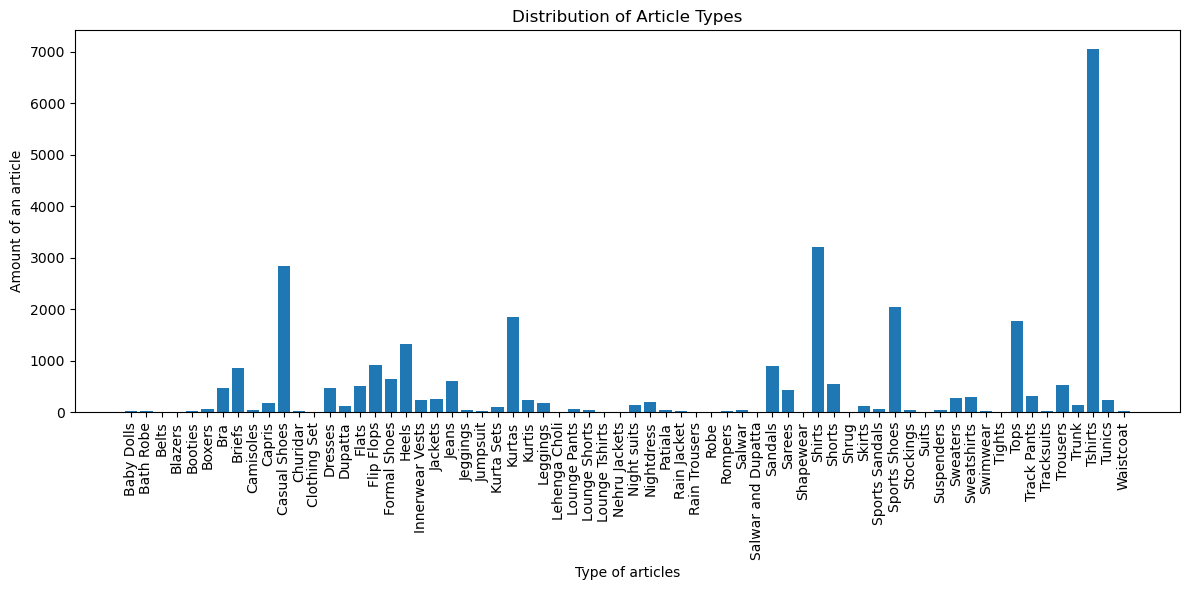

In [ ]:
import matplotlib.pyplot as plt

articles = fashion_df.groupby(['articleType']).size().reset_index(name='counts')

plt.figure(figsize=(12,6))
plt.bar(articles['articleType'], articles['counts'])
plt.xticks(rotation=90)
plt.xlabel('Type of articles')
plt.ylabel('Amount of an article')
plt.title('Distribution of Article Types')
plt.tight_layout()
plt.show()

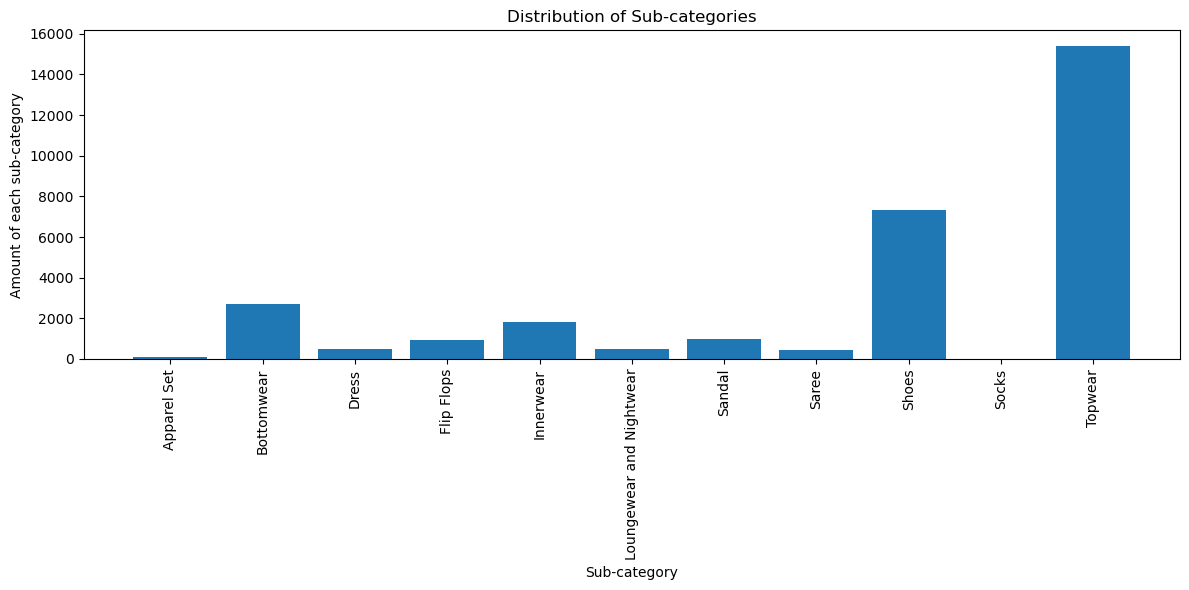

In [29]:
import matplotlib.pyplot as plt

subCategories = fashion_df.groupby(['subCategory']).size().reset_index(name='counts')

plt.figure(figsize=(12,6))
plt.bar(subCategories['subCategory'], subCategories['counts'])
plt.xticks(rotation=90)
plt.xlabel('Sub-category')
plt.ylabel('Amount of each sub-category')
plt.title('Distribution of Sub-categories')
plt.tight_layout()
plt.show()

In [30]:
reduced_fashion = fashion_df[(fashion_df['subCategory'] == 'Topwear') | (fashion_df['subCategory'] == 'Bottomwear') | (fashion_df['subCategory'] == 'Shoes')]
reduced_fashion

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
...,...,...,...,...,...,...,...,...,...,...
44415,13496,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts
44417,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt
44418,42234,Women,Apparel,Topwear,Tops,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe


In [36]:
subCategories_reduce = reduced_fashion.groupby(['subCategory']).size().reset_index(name='counts')
articles_reduce = reduced_fashion.groupby(['articleType']).size().reset_index(name='counts')
mix = reduced_fashion.groupby(['subCategory', 'articleType']).size().reset_index(name='counts')

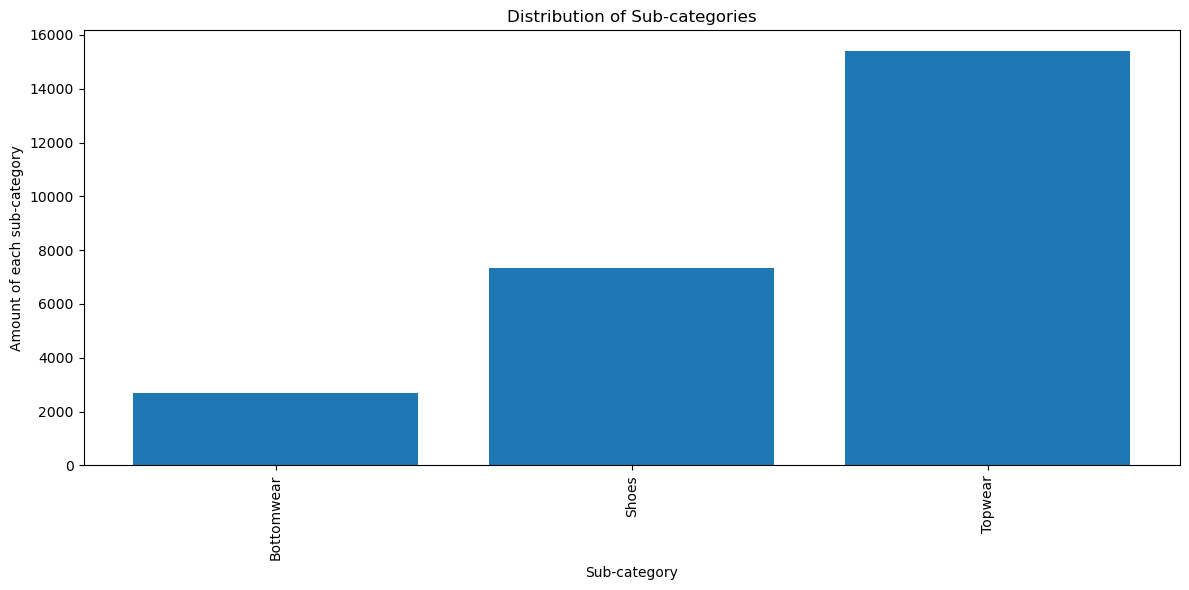

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(subCategories_reduce['subCategory'], subCategories_reduce['counts'])
plt.xticks(rotation=90)
plt.xlabel('Sub-category')
plt.ylabel('Amount of each sub-category')
plt.title('Distribution of Sub-categories')
plt.tight_layout()
plt.show()

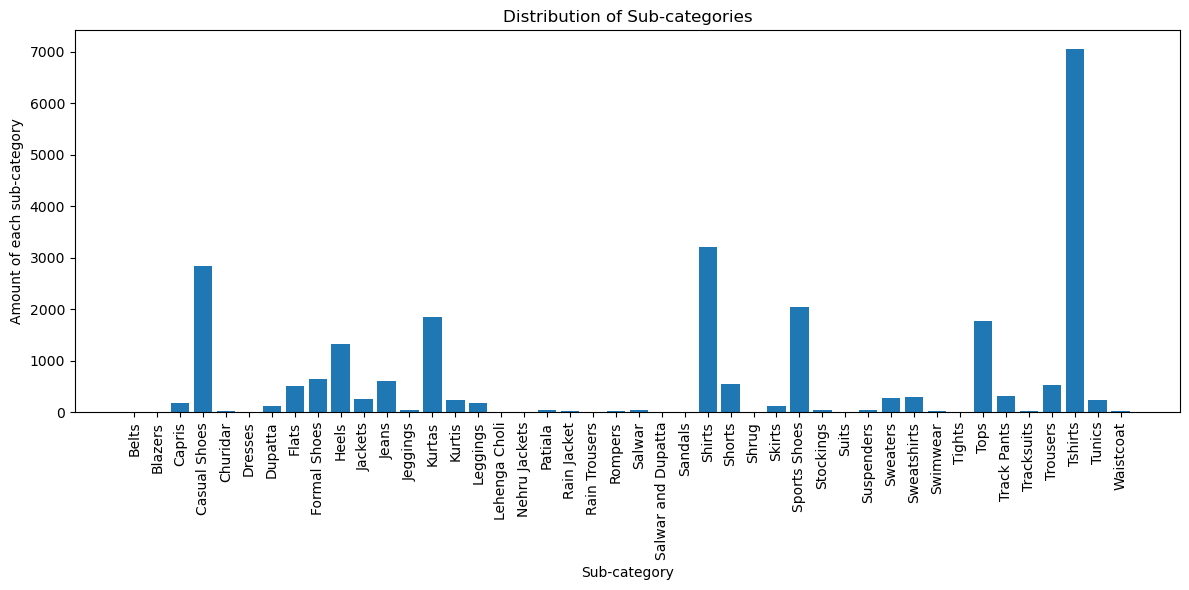

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(articles_reduce['articleType'], articles_reduce['counts'])
plt.xticks(rotation=90)
plt.xlabel('Sub-category')
plt.ylabel('Amount of each sub-category')
plt.title('Distribution of Sub-categories')
plt.tight_layout()
plt.show()

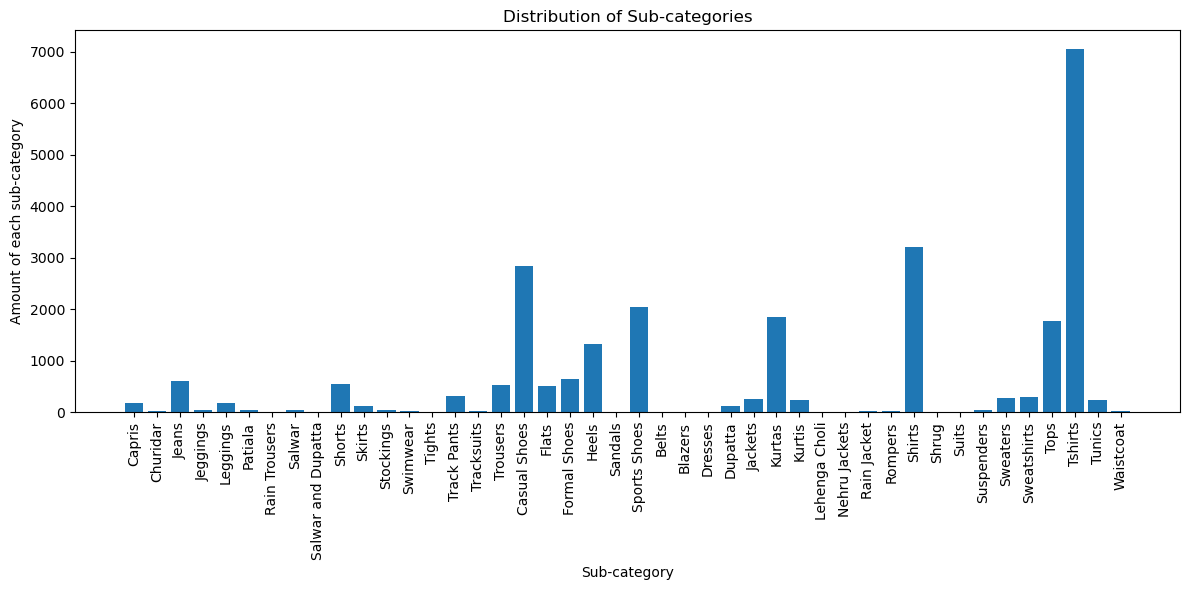

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.bar(mix['articleType'], mix['counts'])
plt.xticks(rotation=90)
plt.xlabel('Sub-category')
plt.ylabel('Amount of each sub-category')
plt.title('Distribution of Sub-categories')
plt.tight_layout()
plt.show()

In [89]:
test_subcategories = articles_reduce[articles_reduce['counts'] >= 500]
test_subcategories

,articleType,counts
3,Casual Shoes,2845
7,Flats,500
8,Formal Shoes,637
9,Heels,1323
11,Jeans,609
13,Kurtas,1844
25,Shirts,3217
26,Shorts,545
29,Sports Shoes,2036
37,Tops,1762


I have reduced the number of possible prediction categories be a arbitrary threshold due to the fact that a lot of the categories have close to no datapoints. Therefore, to both reduce the number of output categorie to a more digestible number, it is also to better balance the need for bias introduced in the model.


Casual Shoes --> 0 
Flats        --> 1
Formal Shoes --> 3
Heels        --> 4
Jeans        --> 5
Kurtas       --> 6
Shirts       --> 7
Shorts       --> 8
Sports shoes --> 9
Tops         --> 10
Trousers     --> 11
Tshirts      --> 12

## Trying LeNet-5 on new real-world (noisy) dataset:

In [119]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmetrics import Accuracy


In [90]:
test_subcategories.reset_index(inplace=True)
test_subcategories.drop(['index', 'counts'], inplace=True, axis=1)
test_subcategories

C:\Users\amali\AppData\Local\Temp\ipykernel_12360\4229601107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_subcategories.drop(['index', 'counts'], inplace=True, axis=1)


,articleType
0,Casual Shoes
1,Flats
2,Formal Shoes
3,Heels
4,Jeans
5,Kurtas
6,Shirts
7,Shorts
8,Sports Shoes
9,Tops


In [91]:
mapping_dict = {category: idx for idx, category in enumerate(test_subcategories['articleType'])}

In [56]:
reduced_fashion.head(5)
print(reduced_fashion.shape)

(25439, 10)


In [58]:
# Merge the selected number of articleTypes with the full data frame:
merged_df = pd.merge(reduced_fashion, test_subcategories, how='left', on=['articleType']).dropna()
print('Number of fashion articles: ', len(set(merged_df['articleType'])))
print('Shape of new fashion dataframe: ', merged_df.shape)

Number of fashion articles:  12
Shape of new fashion dataframe:  (22884, 11)


In [46]:
test_img = int(reduced_fashion.iloc[0,0])
print(test_img)

15970


In [ ]:
reduced_fashion

img_path = f'data/images/{test_img}.jpg'
print(img_path)

img = Image.open(img_path)

print('Mode: ', img.mode)
print('Size: ', img.size)

data/images/15970.jpg
Mode:  RGB
Size:  (60, 80)


In [130]:
def processImg(img_path):
    process = transforms.Compose([
        transforms.Resize((60, 80)),
        transforms.ToTensor()
    ])

    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB') #To ensure 3 channels
        img_tensor = process(img).unsqueeze(0)
        return img_tensor
    else:
        return None

In [131]:
merged_df['img_tensor'] = merged_df['id'].map(lambda x: processImg(f'data/images/{x}.jpg'))

In [140]:
#merged_df.drop('counts', axis=1, inplace=True)
merged_df.dropna(subset=['img_tensor'], inplace=True)
merged_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,img_tensor
0,15970,Men,Apparel,Topwear,6,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
1,39386,Men,Apparel,Bottomwear,4,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
3,53759,Men,Apparel,Topwear,11,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
4,1855,Men,Apparel,Topwear,11,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
5,30805,Men,Apparel,Topwear,6,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
...,...,...,...,...,...,...,...,...,...,...,...
25434,13496,Men,Apparel,Topwear,11,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
25435,12544,Women,Apparel,Topwear,11,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
25436,42234,Women,Apparel,Topwear,9,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
25437,17036,Men,Footwear,Shoes,0,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,"[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."


In [92]:
merged_df['articleType'] = merged_df['articleType'].map(mapping_dict)

In [93]:
merged_df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,img_tensor
0,15970,Men,Apparel,Topwear,6,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
1,39386,Men,Apparel,Bottomwear,4,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
3,53759,Men,Apparel,Topwear,11,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
4,1855,Men,Apparel,Topwear,11,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
5,30805,Men,Apparel,Topwear,6,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
...,...,...,...,...,...,...,...,...,...,...,...
25434,13496,Men,Apparel,Topwear,11,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
25435,12544,Women,Apparel,Topwear,11,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
25436,42234,Women,Apparel,Topwear,9,Blue,Summer,2012.0,Casual,Sepia Women Blue Printed Top,"[[[tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0..."
25437,17036,Men,Footwear,Shoes,0,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,"[[[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.,..."


So I need to modify the LeNet-5 architecture (the input pipeline) to match the images new dimensions 60x80 from the previous 28x28 dimensions. As well as the switch to RGB images compared to the previous use of grayscale images, meaning the input channel should be changed from 1 to 3. 

In [134]:
# Define the model architecture - LeNet-5


class LeNet5_New(nn.Module):
    def __init__(self):
        
        """ Initialize the LeNet-5 model architecture 
        
        Parameters:
        in_channels (int): Number of input channels (e.g., 1 for grayscale images, 3 for RGB images)
        num_classes (int): Number of output classes for classification
        """
        
        super().__init__()

        # Modified for a new input pipeline (60x80 RGB images)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)   # 60x80x3  --> 60x80x6
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                          # 60x80x6  --> 30x40x6
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)  # 30x40x6  --> 26x36x16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                          # 26x36x16 --> 13x18x16 
        self.fc1 = nn.Linear(in_features=13 * 18 * 16, out_features=120)                            # 3744     --> 120
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with a dropout probability of 0.5
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.dropout = nn.Dropout(p=0.3)  # Dropout layer with a dropout probability of 0.3
        self.out = nn.Linear(in_features=84, out_features=12)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.reshape(x.shape[0], -1)   # Flatten the tensor

        x = F.relu(self.fc1(x))         # First fully connected layer with ReLu activation
        x = self.dropout(x)              # Apply dropout for regularization
        x = F.relu(self.fc2(x))         # Second fully connected layer with ReLu activation
        x = self.dropout(x)              # Apply dropout for regularization
        x = self.out(x)
        return x                         # Output layer (logits for each class)

In [79]:
def getDevice():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [127]:
def accuracy(y_pred, y_true):
    return Accuracy(task="multiclass", num_classes=12).to('cuda' if torch.cuda.is_available() else 'cpu')(y_pred, y_true)

In [104]:
def reshapeTensor(X, img_row=60, img_col=80):
    return torch.tensor(X.to_numpy().reshape(-1, 3, img_row, img_col).astype('float32') / 255.0)

In [94]:
def getDataLabels(y):
    return torch.tensor(y.values.astype('int64'))

In [141]:
X = merged_df['img_tensor']
y = merged_df['articleType']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
model = LeNet5_New()
model.to(getDevice())
loss = nn.CrossEntropyLoss() # Loss function for multi-class classification (using Softmax by default in PyTorch)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate of 0.001

num_epochs=50
batch_size=128

# Training loop for batches of training data
for epoch in range(num_epochs):
    model.train()
    train_loss, train_accuracy = 0, 0

    for i in range(0, len(X_train), batch_size):
    
        batch_list = [row.squeeze(0) for row in X_train[i:i+batch_size]]  # remove the extra batch dim
        X_batch = torch.stack(batch_list).to(getDevice())  # shape: (batch_size, 3, H, W)
        y_batch = getDataLabels(y_train[i:i+batch_size])

        #print('X_batch: ', X_batch)
        #print('y_batch: ', y_batch.type)

        X_batch, y_batch = X_batch.to(getDevice()), y_batch.to(getDevice()) # Set to the same device as model

        # Forward pass
        train_result = model(X_batch)
        batch_loss = loss(train_result, y_batch) # Compute batch loss
        train_loss += batch_loss.item() * X_batch.size(0) # Accumulate loss over the epoch

        optimizer.zero_grad()           # Clear gradients from previous step

        # Backward pass and optimization
        batch_loss.backward()
        optimizer.step()

        #print('Train Result Shape: ', train_result.shape)
        #print('y_batch shape: ', y_batch.shape)

        acc = accuracy(train_result, y_batch).item() # Compute batch accuracy
        train_accuracy += acc * X_batch.size(0) # Accumulate accuracy over the epoch

    train_loss /= len(X_train)
    train_accuracy /= len(X_train)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')


# Validation loop for whole validation set
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient calculation for validation
    X_val_tensor = torch.stack([x.squeeze(0) for x in X_val]).to(getDevice())
    y_val_tensor = getDataLabels(y_val).to(getDevice())

    # Forward pass
    val_result = model(X_val_tensor)
    val_loss = loss(val_result, y_val_tensor)
    val_acc = accuracy(val_result, y_val_tensor)
    print(f'Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_acc * 100:.2f}%')

Epoch [1/50], Loss: 1.4984, Accuracy: 0.4542
Epoch [2/50], Loss: 0.7919, Accuracy: 0.6884
Epoch [3/50], Loss: 0.6582, Accuracy: 0.7397
Epoch [4/50], Loss: 0.5894, Accuracy: 0.7696
Epoch [5/50], Loss: 0.5478, Accuracy: 0.7861
Epoch [6/50], Loss: 0.5084, Accuracy: 0.7979
Epoch [7/50], Loss: 0.4831, Accuracy: 0.8102
Epoch [8/50], Loss: 0.4602, Accuracy: 0.8178
Epoch [9/50], Loss: 0.4340, Accuracy: 0.8294
Epoch [10/50], Loss: 0.4245, Accuracy: 0.8310
Epoch [11/50], Loss: 0.3936, Accuracy: 0.8455
Epoch [12/50], Loss: 0.3827, Accuracy: 0.8503
Epoch [13/50], Loss: 0.3680, Accuracy: 0.8537
Epoch [14/50], Loss: 0.3519, Accuracy: 0.8586
Epoch [15/50], Loss: 0.3406, Accuracy: 0.8658
Epoch [16/50], Loss: 0.3346, Accuracy: 0.8656
Epoch [17/50], Loss: 0.3217, Accuracy: 0.8714
Epoch [18/50], Loss: 0.3053, Accuracy: 0.8765
Epoch [19/50], Loss: 0.2983, Accuracy: 0.8802
Epoch [20/50], Loss: 0.2938, Accuracy: 0.8839
Epoch [21/50], Loss: 0.2851, Accuracy: 0.8872
Epoch [22/50], Loss: 0.2667, Accuracy: 0.89